# Libraries and Data Import

In [0]:
import sys
%tb

#import pyspark.sql tools
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, when
from pyspark.sql.types import DoubleType
from functools import reduce

#import python libraries and modules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statistics
from scipy.stats import chi2_contingency
from itertools import combinations

#import ml tools
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [0]:
%sh wget -P /dbfs/tmp/ https://data.nber.org/nvss/natality/csv/2023/natality2023us.csv
#read in data from NBER website

In [0]:
#create spark session
spark = SparkSession.builder.appName('natality').getOrCreate()

#read file into spark frame
natality = spark.read.csv('file:/create/temp/file', header=True, inferSchema=True)

#create SQL table to use for querying
natality.createOrReplaceTempView('natality_tbl')

In [0]:
display(natality.head())

Row(dob_yy=2023, dob_mm=1, dob_tt=117, dob_wk=1, bfacil=1, f_bfacil=1, bfacil3=1, mage_impflg=None, mage_repflg=None, mager=37, mager14=11, mager9=6, mbstate_rec=1, restatus=1, mrace31=3, mrace6=3, mrace15=3, mraceimp=None, mhispx=0, mhisp_r=0, f_mhisp=1, mracehisp=3, mar_p='Y', dmar=2, mar_imp=None, f_mar_p=1, meduc=7, f_meduc=1, fagerpt_flg=None, fagecomb=33, fagerec11=5, frace31=1, frace6=1, frace15=1, fhispx=0, fhisp_r=0, f_fhisp=1, fracehisp=1, feduc=5, f_feduc=1, priorlive=1, priordead=0, priorterm=1, lbo_rec=2, tbo_rec=3, illb_r=28, illb_r11=4, ilop_r=202, ilop_r11=8, ilp_r=28, ilp_r11=4, precare=3, f_mpcb=1, precare5=1, previs=12, previs_rec=7, f_tpcv=1, wic='N', f_wic=1, cig_0=0, cig_1=0, cig_2=0, cig_3=0, cig0_r=0, cig1_r=0, cig2_r=0, cig3_r=0, f_cigs_0=1, f_cigs_1=1, f_cigs_2=1, f_cigs_3=1, cig_rec='N', f_tobaco=1, m_ht_in=64, f_m_ht=1, bmi=24.0, bmi_r=2, pwgt_r=140, f_pwgt=1, dwgt_r=156, f_dwgt=1, wtgain=16, wtgain_rec=2, f_wtgain=1, rf_pdiab='N', rf_gdiab='N', rf_phype='N'

#ML Process

In [0]:
#the following features are various reporting flags for the dataset
flags = ['f_bfacil', 'mage_repflg', 'f_mhisp', 'f_mar_p', 'f_meduc', 'f_fhisp', 'f_feduc', 'f_mpcb', 'f_tpcv', 'f_wic', 'f_tobaco', 'f_m_ht', 'f_pwgt', 'f_dwgt', 'f_wtgain', 'f_rf_pdiab', 'f_rf_gdiab', 'f_rf_phyper', 'f_rf_ghyper', 'f_rf_eclamp', 'f_rf_ppb', 'f_rf_inft', 'f_rf_inf_drg', 'f_rf_inf_art', 'f_rf_cesar', 'f_rf_ncesar', 'f_ip_gonor', 'f_ip_syph', 'f_ip_chlam', 'f_ip_hepatb', 'f_ip_hepatc', 'f_ob_succ', 'f_ob_fail', 'f_ld_indl', 'f_ld_augm', 'f_ld_ster', 'f_ld_antb', 'f_ld_chor', 'f_ld_anes', 'f_me_pres', 'f_me_rout', 'f_me_trial', 'f_dmeth_rec', 'f_mm_mtr', 'f_mm_', 'f_mm_rupt', 'f_mm_uhyst', 'f_mm_aicu', 'f_pay', 'f_pay_rec', 'f_apgar5', 'obgest_flg', 'lmpused', 'f_ab_vent', 'f_ab_vent6', 'f_ab_niuc', 'f_ab_surfac', 'f_ab_antibio', 'f_ab_seiz', 'f_ca_anen', 'f_ca_menin', 'f_ca_heart', 'f_ca_hernia', 'f_ca_ompha', 'f_ca_gastro', 'f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom', 'f_ca_hypos', 'f_bfed', 'fagerpt_flg']

In [0]:
#the following features are locations
location = ['mbstate_rec','restatus','octerr', 'ocntyfips', 'ocntypop', 'mbcntry', 'mrcntry', 'mrterr', 'rcnty', 'rcnty_pop', 'rcity_pop', 'rectype']

#imputed columns
imputed = ['mage_impflg', 'mraceimp', 'mar_imp', 'imp_plur', 'imp_sex', 'compgst_imp']

#the following features are related to mothers not considered low-risk
not_lowrisk = ['priorlive', 'priordead', 'tbo_rec', 'illb_r', 'illb_r11', 'ilop_r', 'ilop_r11', 'ilp_r', 'ilp_r11', 'rf_ppterm', 'rf_cesar', 'rf_cesarn', 'ob_ecvs', 'ob_ecvf']

#features related to the father
father = ['fagecomb', 'fagerec11', 'frace6', 'frace15', 'fhispx', 'fhisp_r', 'fracehisp', 'feduc', 'frace31']

#other maternal features
maternal_other = ['dlmp_mm', 'dlmp_yy', 'combgest', 'gestrec10', 'gestrec3', 'no_risks', 'no_infec']

#the following are based on delivery and could potentially lead to leaky data
delivery_outcomes = ['ld_indl', 'ld_augm', 'ld_ster', 'ld_antb', 'ld_chor', 'ld_anes', 'no_lbrdlv', 'me_trial', 'me_rout', 'rdmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_aicu', 'no_mmorb', 'mm_uhyst', 'attend', 'mtran']

newborn_outcomes = ['apgar5', 'apgar5r', 'apgar10', 'apgar10r', 'bwtr4', 'setorder_r', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'no_abnorm', 'itran', 'bfed', 'ilive', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_down', 'ca_disor', 'ca_hypo']

#additional columns to remove
misc = ['dob_yy', #this is the same for all births in dataset
        'mager14', 'mrace6', 'mrace31', 'mracehisp', 'pay_rec', 'bfacil3', 'mhispx']

In [0]:
#create empty list and extend list to include lists of features to drop
check = []
check.extend(flags)
check.extend(location)
check.extend(imputed)
check.extend(not_lowrisk)
check.extend(father)
check.extend(maternal_other)
check.extend(delivery_outcomes)
check.extend(newborn_outcomes)
check.extend(misc)

In [0]:
#drop master list from dataframe
natality = natality.drop(*check)

In [0]:
'''
This portion of the code filters for low-risk women based on the defined methodology according to Healthy People 2023. 

Low-risk female:
    - nulliparous (never given birth before - per the user guide, "parity indicates how many live births a mother has had")
    - full-term (>=37 weeks gestation, based on ob estimate at delivery)
    - singleton pregnancy (not multiple, e.g. twins or higher)
    - vertex fetus (head facing downward/aka cephalic, opposite of breech)

The corresponding NVSS fields are:
    - nulliparous: lbo_rec = 1
    - full-term: oegest_r3 = 2 (37 weeks & over)
    - singleton pregnancy: dplural = 1
    - vertex: me_pres = 1
'''
low_risk = natality.filter(
    (col('lbo_rec') == 1) &
    (col('oegest_r3') == 2) &
    (col('dplural') == 1) &
    (col('me_pres') == 1)
)

#drop filtering columns
drops = ['lbo_rec', 'oegest_r3', 'dplural', 'me_pres']
low_risk = low_risk.drop(*drops)

In [0]:
#filter dataframe so that only truth values are included
low_risk = low_risk.filter(col('dmeth_rec') != 9)
print(f'Low-risk Delivery Type Known: {low_risk.count()}')

#convert delivery column to boolean
low_risk = low_risk.withColumn('label', F.when(col('dmeth_rec')==1, 0).otherwise(1))

Low-risk Delivery Type Known: 1218318


In [0]:
#create dictionary for unknowns 
unknown_features = {
    'dob_tt':9999, 
    'priorterm':99, 
    'precare':99, 
    'previs':99, 
    'cig_0':99, 
    'cig_1':99, 
    'cig_2':99, 
    'cig_3':99, 
    'm_ht_in':99, 
    'bmi':99.9000015258789, 
    'wtgain':99, 
    'dwgt_r':99, 
    'dbwt':9999, 
    'pwgt_r':99, 
    'oegest_comb':99, 
    'mhisp_r':9, 
    'mar_p':'U', 
    'wic':'U', 
    'rf_pdiab':'U', 
    'rf_gdiab':'U', 
    'rf_phype':'U', 
    'rf_ghype':'U', 
    'rf_ehype':'U', 
    'rf_inftr':'U', 
    'rf_fedrg':'U', 
    'rf_artec':'U', 
    'ip_gon':'U', 
    'ip_syph':'U', 
    'ip_chlam':'U', 
    'ip_hepb':'U', 
    'ip_hepc':'U', 
    'pay':9, 
    'bfacil':9, 
    'cig_rec':'U', 
    'no_congen':9,
    'meduc': 6,
    'precare5': 5,
    'previs_rec': 12,
    'cig0_r': 6,
    'cig1_r': 6,
    'cig2_r': 6, 
    'cig3_r': 6,
    'bmi_r': 9,
    'wtgain_rec': 9,
    'oegest_r10': 99,
    'bwtr12': 12
}

In [0]:
#drop rows from dataframe if they contain one of the "unknown" values 
conditions = [
    col(feature) != unknown_val
    for feature, unknown_val in unknown_features.items()
]

#combine all conditions
combined = reduce(lambda a, b: a & b, conditions)

#apply filter
low_risk_cleaned = low_risk.filter(combined)

In [0]:
print(low_risk_cleaned.count())

749224


In [0]:
#recode cig_rec to boolean
low_risk_cleaned = low_risk_cleaned.withColumn(
    'cig_rec_bool',
    when((col('cig_rec') == 'U'), None)
    .when(col('cig_rec') == 'Y', 1)
    .otherwise(0)
)

#recode cigarette smoking to boolean - before pregnancy
low_risk_cleaned = low_risk_cleaned.withColumn(
    'cig0_bool',
    when((col('cig_0') == 99), None)
    .when(col('cig_0') >0, 1)
    .otherwise(0)
)

#recode 1st trimester smoking
low_risk_cleaned = low_risk_cleaned.withColumn(
    'cig1_bool',
    when((col('cig_1') == 99), None)
    .when(col('cig_1') > 0, 1)
    .otherwise(0)
)

#recode 2nd trimester smoking
low_risk_cleaned = low_risk_cleaned.withColumn(
    'cig2_bool',
    when((col('cig_2') == 99), None)
    .when(col('cig_2') > 0, 1)
    .otherwise(0)
)

#recode 3rd trimester smoking
low_risk_cleaned = low_risk_cleaned.withColumn(
    'cig3_bool',
    when((col('cig_3') == 99), None)
    .when(col('cig_3') > 0, 1)
    .otherwise(0)
)

In [0]:
#continuous variable list
cont_1 = ['mager', 'precare', 'previs', 'bmi', 'wtgain', 'oegest_comb', 'dbwt']

#categorical variable list
cat_2 = ['mager9', 'precare5', 'previs_rec', 'bmi_r', 'wtgain_rec', 'oegest_r10', 'bwtr12']

#cigarette booleans
cigbytrim = ['cig0_bool', 'cig1_bool', 'cig2_bool', 'cig3_bool']
allcig = ['cig_rec_bool']

#list of continuous features to use in both
cont_both = ['dob_tt', 'm_ht_in', 'dwgt_r', 'priorterm']

#ordinal features
ordinal_both = ['dob_mm', 'dob_wk', 'meduc']

#list of categorical/ordinal features to use in both
cat_both = ['bfacil', 'mrace15', 'mhisp_r', 'mar_p', 'dmar', 'wic', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'ip_gon', 'ip_syph', 'ip_chlam', 'ip_hepb', 'ip_hepc', 'pay', 'sex', 'no_congen']

unknown_list = ['dob_tt_unknown', 'priorterm_unknown', 'precare_unknown', 'previs_unknown', 'cig_0_unknown', 'cig_1_unknown', 'cig_2_unknown', 'cig_3_unknown', 'm_ht_in_unknown', 'bmi_unknown', 'wtgain_unknown', 'dwgt_r_unknown', 'dbwt_unknown', 'pwgt_r_unknown', 'oegest_comb_unknown', 'mhisp_r_unknown', 'mar_p_unknown', 'wic_unknown', 'rf_pdiab_unknown', 'rf_gdiab_unknown', 'rf_phype_unknown', 'rf_ghype_unknown', 'rf_ehype_unknown', 'rf_inftr_unknown', 'rf_fedrg_unknown', 'rf_artec_unknown', 'ip_gon_unknown', 'ip_syph_unknown', 'ip_chlam_unknown', 'ip_hepb_unknown', 'ip_hepc_unknown', 'pay_unknown', 'bfacil_unknown', 'cig_rec_unknown', 'no_congen_unknown', 'meduc_unknown', 'precare5_unknown', 'previs_rec_unknown', 'cig0_r_unknown', 'cig1_r_unknown', 'cig2_r_unknown', 'cig3_r_unknown', 'bmi_r_unknown', 'wtgain_rec_unknown', 'oegest_r10_unknown', 'bwtr12_unknown']

In [0]:
#randomly split data into training and test sets, and set seed for reproductibility
trainDF, testDF = low_risk_cleaned.randomSplit([0.8, 0.2], seed=42)
print(trainDF.cache().count())
print(testDF.count())

599386
149838


In [0]:
#review dataframe
display(trainDF)

In [0]:
#handle class imbalance
minority = trainDF.filter(col('label') == 1)
majority = trainDF.filter(col('label') == 0)

minor_count = minority.count()
major_count = majority.count()

#randomly undersample from majority
from pyspark.sql.functions import rand
majority_downsample = majority.orderBy(rand()).limit(minor_count)

#merge minority and the downsampled
train_balanced = minority.union(majority_downsample)

In [0]:
train_balanced.printSchema()

root
 |-- dob_mm: integer (nullable = true)
 |-- dob_tt: integer (nullable = true)
 |-- dob_wk: integer (nullable = true)
 |-- bfacil: integer (nullable = true)
 |-- mager: integer (nullable = true)
 |-- mager9: integer (nullable = true)
 |-- mrace15: integer (nullable = true)
 |-- mhisp_r: integer (nullable = true)
 |-- mar_p: string (nullable = true)
 |-- dmar: integer (nullable = true)
 |-- meduc: integer (nullable = true)
 |-- priorterm: integer (nullable = true)
 |-- precare: integer (nullable = true)
 |-- precare5: integer (nullable = true)
 |-- previs: integer (nullable = true)
 |-- previs_rec: integer (nullable = true)
 |-- wic: string (nullable = true)
 |-- cig_0: integer (nullable = true)
 |-- cig_1: integer (nullable = true)
 |-- cig_2: integer (nullable = true)
 |-- cig_3: integer (nullable = true)
 |-- cig0_r: integer (nullable = true)
 |-- cig1_r: integer (nullable = true)
 |-- cig2_r: integer (nullable = true)
 |-- cig3_r: integer (nullable = true)
 |-- f_cigs_0: integer

In [0]:
def build_and_evaluate_pipeline(train_df, test_df, config, feature_list, categorical_features, label_col='label', model_names=['LogisticRegression', 'RandomForest'], num_folds=3):
    '''
    This function wraps in all of the pipeline functions, including string indexing, encoding, vector assembly, setting parameters, building pipeline, defining evaluation, cross-validation, training the model, evaluating, displaying convergence, and appending results.
    '''
    results = []

    #string index and onehotencoder
    indexers = [StringIndexer(inputCol=col, outputCol=f'{col}_idx', handleInvalid='keep') for col in categorical_features]
    encoders = [OneHotEncoder(inputCol=f'{col}_idx', outputCol=f'{col}_ohe', handleInvalid='keep') for col in categorical_features]
    encoded_features = [f'{col}_ohe' for col in categorical_features]
    numeric_features = [f for f in feature_list if f not in categorical_features]

    final_features = numeric_features + encoded_features
    assembler = VectorAssembler(inputCols=final_features, outputCol='features', handleInvalid='keep')

    #set up models
    models = {
        'LogisticRegression': LogisticRegression(labelCol=label_col, featuresCol='features'),
        'RandomForest': RandomForestClassifier(labelCol=label_col, featuresCol='features')
    }

    for name in model_names:
        model = models[name]

        #paramters
        if name == 'LogisticRegression':
            paramGrid = ParamGridBuilder().addGrid(model.regParam, [0.1, 1.0]).build()
        else:
            paramGrid = ParamGridBuilder().addGrid(model.numTrees, [50, 100]).build()
        
        #setup pipeline
        pipeline = Pipeline(stages=indexers + encoders + [assembler, model])

        #define evaluations
        evaluator_auc = BinaryClassificationEvaluator(labelCol=label_col, metricName='areaUnderROC')
        evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, metricName='f1')
        evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, metricName='accuracy')

        #add cross validation
        crossval = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator_auc,
            numFolds=num_folds,
            parallelism=2
        )

        #fit aned predict
        cv_model = crossval.fit(trainDF)
        best_model = cv_model.bestModel
        predictions = best_model.transform(testDF)

        #evaluate
        auc = evaluator_auc.evaluate(predictions)
        f1 = evaluator_f1.evaluate(predictions)
        acc = evaluator_acc.evaluate(predictions)

        #visualize convergence for logistic regression
        if name == 'LogisticRegression':
            training_summary = best_model.stages[-1].summary
            plt.plot(training_summary.objectiveHistory)
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title(f'LogLoss Convergence for {name} - {config}')
            plt.grid(True)
            plt.show()

            display(best_model.stages[-1], predictions.drop('prediction', 'rawPrediction', 'probability'), 'ROC')

        results.append({
            'config': config, 
            'model': name,
            'features_used': feature_list,
            'auc': auc, 
            'f1': f1,
            'accuracy': acc,
            'best_model': best_model
        })

        
    return results

In [0]:
#need to run each configuration one at a time in order to keep compute from terminating
config1 = cont_1 + cigbytrim + cont_both + cat_both + ordinal_both
config2 = cat_2 + cigbytrim + cont_both + cat_both + ordinal_both
config3 = cont_1 + allcig + cont_both + cat_both + ordinal_both
config4 = cat_2 + allcig + cont_both + cat_both + ordinal_both

#create categorical features
cat_odd = cat_both #for config1 and config3
cat_even = cat_both + cat_2 #for config2 and config4

#initialize empty loop for results
all_results = []

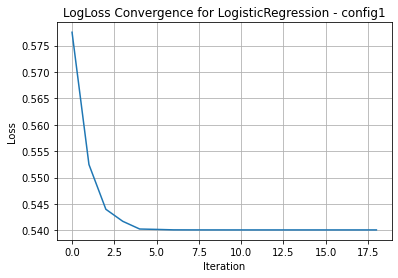

False Positive Rate,True Positive Rate,Threshold
0.0,0.0,0.5878276499902515
0.011363636363636364,0.0,0.5878276499902515
0.011363636363636364,0.047619047619047616,0.5709474201107148
0.022727272727272728,0.047619047619047616,0.5477559672878329
0.03409090909090909,0.047619047619047616,0.45522378273015096
0.03409090909090909,0.09523809523809523,0.45382250303536076
0.03409090909090909,0.14285714285714285,0.4407794593734641
0.045454545454545456,0.14285714285714285,0.4306709526878063
0.056818181818181816,0.14285714285714285,0.40905897653519996
0.056818181818181816,0.19047619047619047,0.40091491011585756


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-662237402228171>:2
      1 #run configuration 1 with cat_odd
----> 2 result1 = build_and_evaluate_pipeline(
      3     train_df = train_balanced,
      4     test_df = testDF,
      5     feature_list = config1,
      6     config = 'config1',
      7     categorical_features = cat_odd,
      8     label_col='label'
      9     )
     11 all_results.extend(result1)

File <command-662237402228149>:79, in build_and_evaluate_pipeline(train_df, test_df, config, feature_list, categorical_features, label_col, model_names, num_folds)
     76 pdf = predictions.select('probability_class1', 'label').toPandas()
     78 #compute ROC curve
---> 79 fpr, tpr, thresholds = roc_curve(pdf['label'], pdf['probability_class1'])
     80 roc_auc = auc(fpr, tpr)
     82 #plot curve

NameError: name 'roc_curve' is not defined

In [0]:
#run configuration 1 with cat_odd
result1 = build_and_evaluate_pipeline(
    train_df = train_balanced,
    test_df = testDF,
    feature_list = config1,
    config = 'config1',
    categorical_features = cat_odd,
    label_col='label'
    )

all_results.extend(result1)

In [0]:
all_results.extend(result1)

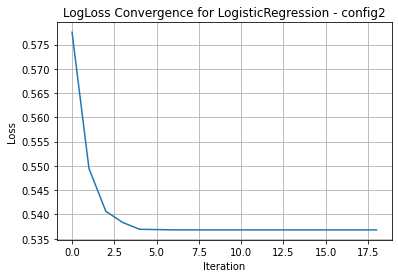

False Positive Rate,True Positive Rate,Threshold
0.0,0.0,0.6799847589221129
0.0,0.047619047619047616,0.6799847589221129
0.011363636363636364,0.047619047619047616,0.6157988193239909
0.022727272727272728,0.047619047619047616,0.5473358714849934
0.022727272727272728,0.09523809523809523,0.4606930016573101
0.022727272727272728,0.14285714285714285,0.4530163017245855
0.03409090909090909,0.14285714285714285,0.44829211918971146
0.03409090909090909,0.19047619047619047,0.4413815292847372
0.045454545454545456,0.19047619047619047,0.42310062905471124
0.045454545454545456,0.23809523809523808,0.4216166872711753


In [0]:
#run configuration 2 with cat_even
result2 = build_and_evaluate_pipeline(
    train_df = train_balanced,
    test_df = testDF,
    feature_list = config2,
    config = 'config2',
    categorical_features = cat_even,
    label_col='label'
    )

all_results.extend(result2)

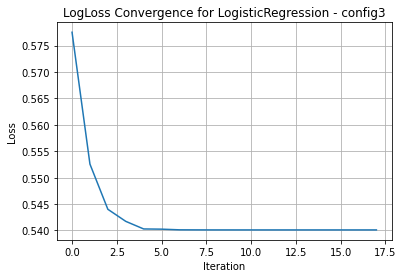

False Positive Rate,True Positive Rate,Threshold
0.0,0.0,0.5881682883171357
0.011363636363636364,0.0,0.5881682883171357
0.011363636363636364,0.047619047619047616,0.5684198256541296
0.022727272727272728,0.047619047619047616,0.5478011103600209
0.03409090909090909,0.047619047619047616,0.4563974687733908
0.03409090909090909,0.09523809523809523,0.45381596645047706
0.03409090909090909,0.14285714285714285,0.4406700275357247
0.045454545454545456,0.14285714285714285,0.4309590798073665
0.056818181818181816,0.14285714285714285,0.40969623755507745
0.056818181818181816,0.19047619047619047,0.4014933668550553


In [0]:
#run configuration 3 with cat_odd
result3 = build_and_evaluate_pipeline(
    train_df = train_balanced,
    test_df = testDF,
    feature_list = config3,
    config = 'config3',
    categorical_features = cat_odd,
    label_col='label'
    )

all_results.extend(result3)

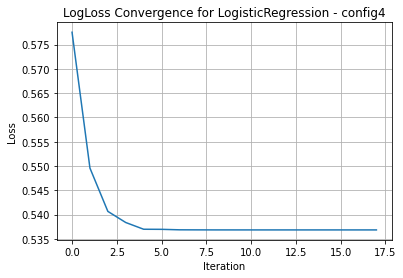

False Positive Rate,True Positive Rate,Threshold
0.0,0.0,0.6778303059842569
0.0,0.047619047619047616,0.6778303059842569
0.011363636363636364,0.047619047619047616,0.6161697146865726
0.022727272727272728,0.047619047619047616,0.5473366978190293
0.022727272727272728,0.09523809523809523,0.461527204291299
0.022727272727272728,0.14285714285714285,0.45300009092365456
0.03409090909090909,0.14285714285714285,0.4493269941215692
0.03409090909090909,0.19047619047619047,0.4412776115969922
0.045454545454545456,0.19047619047619047,0.42353032550412295
0.045454545454545456,0.23809523809523808,0.42225589622744597


In [0]:
#run configuration 4 with cat_even
result4 = build_and_evaluate_pipeline(
    train_df = train_balanced,
    test_df = testDF,
    feature_list = config4,
    config = 'config4',
    categorical_features = cat_even,
    label_col='label'
    )

all_results.extend(result4)

In [0]:
leaderboard_df = pd.DataFrame(all_results)

In [0]:
leaderboard_df.iloc[0, -1] = 'config1'
leaderboard_df.iloc[1, -1] = 'config1'

In [0]:
print(leaderboard_df)

                model                                      features_used  \
0  LogisticRegression  [mager, precare, previs, bmi, wtgain_rec, oege...   
1        RandomForest  [mager, precare, previs, bmi, wtgain_rec, oege...   
2  LogisticRegression  [mager9, precare5, previs_rec, bmi_r, wtgain_r...   
3        RandomForest  [mager9, precare5, previs_rec, bmi_r, wtgain_r...   
4  LogisticRegression  [mager, precare, previs, bmi, wtgain_rec, oege...   
5        RandomForest  [mager, precare, previs, bmi, wtgain_rec, oege...   
6  LogisticRegression  [mager9, precare5, previs_rec, bmi_r, wtgain_r...   
7        RandomForest  [mager9, precare5, previs_rec, bmi_r, wtgain_r...   

        auc        f1  accuracy                  best_model   config  
0  0.704570  0.662541  0.745158  PipelineModel_77d6e9c5e390  config1  
1  0.677714  0.624148  0.735948  PipelineModel_4fa1d268d139  config1  
2  0.709007  0.672275  0.748528  PipelineModel_6aa7d59ff9c3  config2  
3  0.672053  0.623864  0.735828

In [0]:
leaderboard_df_sorted = leaderboard_df.sort_values(by='auc', ascending=False)
display(leaderboard_df_sorted[['config','model', 'auc', 'f1', 'accuracy', 'features_used']])

config,model,auc,f1,accuracy,features_used
config2,LogisticRegression,0.7090068382384901,0.6722752909593845,0.7485284106835383,"List(mager9, precare5, previs_rec, bmi_r, wtgain_rec, oegest_r10, bwtr12, cig0_bool, cig1_bool, cig2_bool, cig3_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
config4,LogisticRegression,0.7090050073030382,0.6722968204233446,0.7485751278046957,"List(mager9, precare5, previs_rec, bmi_r, wtgain_rec, oegest_r10, bwtr12, cig_rec_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
config1,LogisticRegression,0.7045703583691174,0.6625414814109276,0.7451581040857459,"List(mager, precare, previs, bmi, wtgain_rec, oegest_comb, dbwt, cig0_bool, cig1_bool, cig2_bool, cig3_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
config3,LogisticRegression,0.7045677470349481,0.6624362268479234,0.7451247347134906,"List(mager, precare, previs, bmi, wtgain_rec, oegest_comb, dbwt, cig_rec_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
config1,RandomForest,0.6777144363648212,0.6241476990692368,0.735948157343264,"List(mager, precare, previs, bmi, wtgain_rec, oegest_comb, dbwt, cig0_bool, cig1_bool, cig2_bool, cig3_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
config4,RandomForest,0.6756067486380861,0.6239588624767831,0.7358680708498512,"List(mager9, precare5, previs_rec, bmi_r, wtgain_rec, oegest_r10, bwtr12, cig_rec_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
config3,RandomForest,0.6739335343788291,0.6243705245292945,0.7360215699622259,"List(mager, precare, previs, bmi, wtgain_rec, oegest_comb, dbwt, cig_rec_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
config2,RandomForest,0.6720529914823774,0.6238644087911364,0.7358280276031447,"List(mager9, precare5, previs_rec, bmi_r, wtgain_rec, oegest_r10, bwtr12, cig0_bool, cig1_bool, cig2_bool, cig3_bool, dob_tt, m_ht_in, dwgt_r, priorterm, bfacil, mrace15, mhisp_r, mar_p, dmar, wic, rf_pdiab, rf_gdiab, rf_phype, rf_ghype, rf_ehype, rf_inftr, rf_fedrg, rf_artec, ip_gon, ip_syph, ip_chlam, ip_hepb, ip_hepc, pay, sex, no_congen, dob_mm, dob_wk, meduc)"
